## 

## Workshop Day 2

In [41]:
# Dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from util import *

import tensorflow as tf
from tensorflow.keras import datasets, layers, models


# Part 1: Extract data 
Extracting data from  Camargo Dataset

In [3]:
#TODO

Extract data of person walking with exoskeleton. 
For the purpose of this second experiment we will only observe Walking (both in transparent mode and in State Machine mode). 

We create two different df, one for SM one for transparent

In [42]:
df_list = []

# Iterate over all files in the directory
for filename in os.listdir("../data/"):
    if filename.endswith('_ml_dataset_extracted.csv'):
        # Construct full file path
        file_path = os.path.join("../data/", filename)
        # Read CSV file into DataFrame
        df = pd.read_csv(file_path)
        # Append DataFrame to list
        df_list.append(df)

# Concatenate all DataFrames in the list
df = pd.concat(df_list, ignore_index=True)

df_Transparent = df[df['condition'] == 'transparent_WALKING']
df_StateMachine = df[df['condition'] == 'SM_WALKING']


In [51]:

def segment_stride(stance_interpolate_factor, joint, segment_length=100):
    """
    Segments gait using stance interpolation factor

    """
    segments_alpha = []
    segments_theta = []
    start_index = 0
    completed_gait = False

    for i in range(1, len(stance_interpolate_factor)):
        if stance_interpolate_factor[i] == 1:
            completed_gait = True
        elif completed_gait and stance_interpolate_factor[i] == 0:
            segments_alpha.append(stance_interpolate_factor[start_index:i])
            segments_theta.append(joint[start_index:i])
            start_index = i
            completed_gait = False


    gait_phases =[]
    segments_alpha_2 = []
    segments_theta_2 = []
    for segment_al, segment_th in zip(segments_alpha, segments_theta):
        if len(segment_al)< 1500: # remove step too shorts
            x = np.linspace(0, 100, len(segment_al))
            gait_phases.append(x)
            segments_alpha_2.append(segment_al)
            segments_theta_2.append(segment_th)

    return segments_alpha_2, segments_theta_2, gait_phases


In [52]:
# transparent

segmented_joints_transparent ={0:[], 1: [], 2:[], 3:[]}
segmented_alpha_transparent, segmented_joints_transparent[0], gait_phase_transparent = segment_stride( df_Transparent[' StanceInterpolationFactor'].to_numpy(), df_Transparent[' JointPositions_1'].to_numpy())
_, segmented_joints_transparent[1], _ = segment_stride(df_Transparent[' StanceInterpolationFactor'].to_numpy(), df_Transparent[' JointPositions_2'].to_numpy())
_, segmented_joints_transparent[2], _ = segment_stride(df_Transparent[' StanceInterpolationFactor'].to_numpy(), df_Transparent[' JointPositions_3'].to_numpy())
_, segmented_joints_transparent[3], _ = segment_stride(df_Transparent[' StanceInterpolationFactor'].to_numpy(), df_Transparent[' JointPositions_4'].to_numpy())

# State Machine 
segmented_joints_SM= {0:[], 1: [], 2:[], 3:[]}
segmented_alpha_SM, segmented_joints_SM[0], gait_phase_SM = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), df_StateMachine[' JointPositions_1'].to_numpy())
_, segmented_joints_SM[1], _ = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), df_StateMachine[' JointPositions_2'].to_numpy())
_, segmented_joints_SM[2], _ = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), df_StateMachine[' JointPositions_3'].to_numpy())
_, segmented_joints_SM[3], _ = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), df_StateMachine[' JointPositions_4'].to_numpy())

N_STEPS_TRANSPARENT = len(segmented_alpha_transparent)
N_STEPS_SM = len(segmented_alpha_SM)
print("Number steps in transparent:",N_STEPS_TRANSPARENT, "Number steps in SM: ", N_STEPS_SM)

Number steps in transparent: 415 Number steps in SM:  438


Concatenate all steps

In [53]:
segmented_alpha_transparent = np.concatenate(segmented_alpha_transparent)
segmented_joints_transparent[0] = np.concatenate(segmented_joints_transparent[0])
segmented_joints_transparent[1] = np.concatenate(segmented_joints_transparent[1])
segmented_joints_transparent[2] = np.concatenate(segmented_joints_transparent[2])
segmented_joints_transparent[3] = np.concatenate(segmented_joints_transparent[3])
gait_phase_transparent = np.concatenate(gait_phase_transparent)
print(segmented_alpha_transparent.shape, segmented_joints_transparent[0].shape, segmented_joints_transparent[1].shape, segmented_joints_transparent[2].shape,
      segmented_joints_transparent[3].shape, gait_phase_transparent.shape)

segmented_alpha_SM = np.concatenate(segmented_alpha_SM)
segmented_joints_SM[0] = np.concatenate(segmented_joints_SM[0])
segmented_joints_SM[1] = np.concatenate(segmented_joints_SM[1])
segmented_joints_SM[2] = np.concatenate(segmented_joints_SM[2])
segmented_joints_SM[3] = np.concatenate(segmented_joints_SM[3])
gait_phase_SM = np.concatenate(gait_phase_SM)
print(segmented_alpha_SM.shape, segmented_joints_SM[0].shape, segmented_joints_SM[1].shape,
      segmented_joints_SM[2].shape, segmented_joints_SM[3].shape, gait_phase_SM.shape)

(446841,) (446841,) (446841,) (446841,) (446841,) (446841,)
(394732,) (394732,) (394732,) (394732,) (394732,) (394732,)


Plot steps (with mean and variance)

(TODO: remove interpolation)

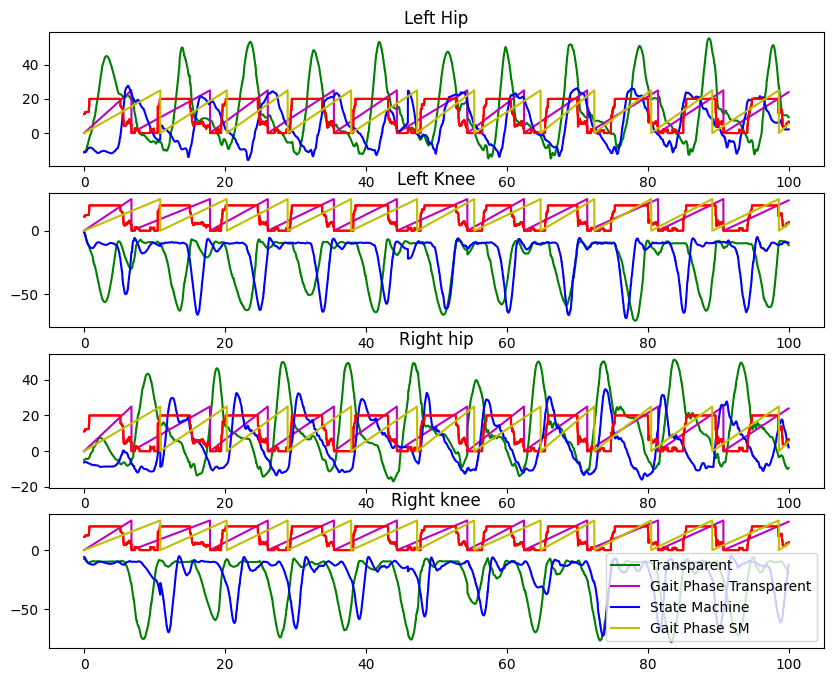

In [148]:
fig, axs = plt.subplots(4, figsize=(10, 8))
axs[0].set_title('Left Hip')
axs[1].set_title('Left Knee')
axs[2].set_title('Right hip')
axs[3].set_title('Right knee')

#transparent
for i in range(4):
    axs[i].plot(np.linspace(0, 100, 10000), (segmented_joints_transparent[i][:10000])*180/np.pi, 'g-', label= "Transparent")
    axs[i].plot(np.linspace(0, 100, 10000),  segmented_alpha_transparent[:10000]*20, 'r-')
    axs[i].plot(np.linspace(0, 100, 10000), gait_phase_transparent[:10000]/4, 'm-', label = "Gait Phase Transparent")

    # STate machine
    axs[i].plot(np.linspace(0, 100, 10000), segmented_joints_SM[i][:10000]*180/np.pi, 'b-', label= "State Machine")
    axs[i].plot(np.linspace(0, 100, 10000), segmented_alpha_transparent[:10000]*20, 'r-')
    axs[i].plot(np.linspace(0, 100, 10000), gait_phase_SM[:10000]/4, 'y-', label = "Gait Phase SM")

plt.legend()
plt.show()

# Part 2: Regression of the gait phase


**Exercice 2** Build Neural Network that receives as input the kinematics and the stance interpolation factor and returns as output the gait phase (x coordidinate previous plot)

We will build two different NN as in *Paper*: CNN and LSTM. (Similar structure but different input in this exercice)




# CNN

**Inputs:** The model had a data input size of 10 channel values (joint position/velocity) for every time step of 5 ms with a window size of 80 data samples. 

Prepare input:

In [202]:
# concatenate joint angles and steps
input_transparent= np.array([segmented_joints_transparent[0], 
                    segmented_joints_transparent[1], 
                    segmented_joints_transparent[2], 
                    segmented_joints_transparent[3]])
# concatenate to input the joint velocity
joint_velocity = np.array([np.gradient(segmented_joints_transparent[0]), 
                    np.gradient(segmented_joints_transparent[1]), 
                    np.gradient(segmented_joints_transparent[2]), 
                    np.gradient(segmented_joints_transparent[3])])
input_transparent = np.concatenate((input_transparent, joint_velocity, [segmented_alpha_transparent]), 0)

# normalize input data
mean= np.mean(input_transparent, 1)[:, np.newaxis]
std = np.std(input_transparent, 1)[:, np.newaxis]
input_transparent= (input_transparent - mean) / std
print("Input Shape ", input_transparent.shape)

# concatenate joint angles and steps
input_SM= np.array([segmented_joints_SM[0], 
                    segmented_joints_SM[1], 
                    segmented_joints_SM[2], 
                    segmented_joints_SM[3]])
# concatenate to input the joint velocity
joint_velocity = np.array([np.gradient(segmented_joints_SM[0]), 
                    np.gradient(segmented_joints_SM[1]), 
                    np.gradient(segmented_joints_SM[2]), 
                    np.gradient(segmented_joints_SM[3])])
input_SM = np.concatenate((input_SM, joint_velocity, [segmented_alpha_SM]), 0)

# normalize input data
mean= np.mean(input_SM, 1)[:, np.newaxis]
std = np.std(input_SM, 1)[:, np.newaxis]
input_SM= (input_SM - mean) / std
print("Input Shape ", input_SM.shape)

Input Shape  (9, 446841)
Input Shape  (9, 394732)


Prepare Output

In [203]:
output_transparent = gait_phase_transparent/100 # created normalized
print("Output transparent shape ", output_transparent.shape)

output_SM = gait_phase_SM/100 # created normalized
print("Output SM shape ", output_SM.shape)

Output transparent shape  (446841,)
Output SM shape  (394732,)


Divide data in time windows: save one value every 5ms, since data is recorded with a frequency of 333Hz the data must be reshaped to have a frequency of 200Hz

In [208]:
import scipy.signal as signal

def divide_time_windows(input, output, window_length, step):
    divided_input = []
    divided_output = []
    
    # downsampling
    ORIGINAL_FREQUENCY = 333
    DESIRED_FREQUENCY = 200
    num_samples = int(input.shape[1] * DESIRED_FREQUENCY / ORIGINAL_FREQUENCY)

    input = signal.resample(input, num_samples, axis=1)
    output = signal.resample(output, num_samples)

    # divide in window
    for i in range(window_length, input.shape[1], step):
        divided_input.append(input[:, i-window_length: i])
        divided_output.append(output[i])
    
    return np.array(divided_input), np.array(divided_output)

In [209]:
WINDOW_LENGTH = 80 #check frequency
STEP = 3
input_transparent, output_transparent = divide_time_windows(input_transparent, output_transparent, WINDOW_LENGTH, STEP)
print("Data transparent Shape: ", input_transparent.shape, output_transparent.shape)

input_SM, output_SM = divide_time_windows(input_SM, output_SM, WINDOW_LENGTH, STEP)
print("Data SM Shape: ", input_SM.shape, output_SM.shape)

Data transparent Shape:  (89431, 9, 80) (89431,)
Data SM Shape:  (78999, 9, 80) (78999,)


Divide training set and output set in training and validation set (70%, 30%). 

In [210]:
train_input_transparent = np.swapaxes(input_transparent[:int(input_transparent.shape[0]*0.7), :, :], 1, 2)
train_output_transparent = output_transparent[:int(input_transparent.shape[0]*0.7)]
val_input_transparent =  np.swapaxes(input_transparent[int(input_transparent.shape[0]*0.7):, :, :], 1, 2)
val_output_transparent = output_transparent[int(input_transparent.shape[0]*0.7):]

print("Transparent ")
print("Training set shape: ", train_input_transparent.shape, train_output_transparent.shape)
print("Validation set shape: ", val_input_transparent.shape, val_output_transparent.shape)

train_input_SM = np.swapaxes(input_SM[:int(input_SM.shape[0]*0.7), :, :], 1, 2)
train_output_SM = output_SM[:int(input_SM.shape[0]*0.7)]
val_input_SM =  np.swapaxes(input_SM[int(input_SM.shape[0]*0.7):, :, :], 1, 2)
val_output_SM = output_SM[int(input_SM.shape[0]*0.7):]

print("State Machine")
print("Training set shape: ", train_input_SM.shape, train_output_SM.shape)
print("Validation set shape: ", val_input_SM.shape, val_output_SM.shape)

Transparent 
Training set shape:  (62601, 80, 9) (62601,)
Validation set shape:  (26830, 80, 9) (26830,)
State Machine
Training set shape:  (55299, 80, 9) (55299,)
Validation set shape:  (23700, 80, 9) (23700,)


**Create Model:** The model had a data input size of 10 channel values (left/right hip position/velocity and trunk IMU) for every
time step of 5 ms with a window size of 80 data samples (Fig. 3). The first layer consisted of a batch normalization, where the
input values were normalized to a zero mean and unit variance. The second layer consisted of a 1D convolution of 10 filters
striding temporally, where each filter had a kernel size of 20. The third layer was another 1D convolution of 10 filters, where
each filter had a kernel size of the previous layer’s window size and compressed the data into a single row vector (representing
the extracted feature information). A sigmoid activation function was applied to this vector and passed the data to a fully connected
dense layer with a tanh activation function.

In [211]:
model_transparent = models.Sequential()
#model.add(layers.BatchNormalization(input_shape=(80,9)))
model_transparent.add(layers.GaussianNoise(0.01, input_shape=(80,9)))
model_transparent.add(layers.Conv1D(10, (20), activation = 'relu'))
model_transparent.add(layers.Conv1D(10, (61), activation = 'sigmoid'))
model_transparent.add(layers.Flatten())
model_transparent.add(layers.Dense(20, activation = 'relu'))
model_transparent.add(layers.Dense(10, activation = 'relu'))
model_transparent.add(layers.Dense(2, activation='tanh'))

model_transparent.summary()

model_SM = models.Sequential()
#model.add(layers.BatchNormalization(input_shape=(80,9)))
model_SM.add(layers.GaussianNoise(0.01, input_shape=(80,9)))
model_SM.add(layers.Conv1D(10, (20), activation = 'relu'))
model_SM.add(layers.Conv1D(10, (61), activation = 'sigmoid'))
model_SM.add(layers.Flatten())
model_SM.add(layers.Dense(20, activation = 'relu'))
model_SM.add(layers.Dense(10, activation = 'relu'))
model_SM.add(layers.Dense(2, activation='tanh'))

C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_21               │ (None, 80, 9)          │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 61, 10)         │         1,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 1, 10)          │         6,110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,372 (32.70 KB)

 Trainable params: 8,372 (32.70 KB)

 Non-trainable params: 0 (0.00 B)

**Loss function:** To ensure that the gait phase error was evaluated accurately during the transition from one gait cycle to the next, where 100 and 0 represent the same value, we used an angular similarity metric by computing the cosine distance between the predicted and the ground truth Cartesian coordinates. The root mean square error (RMSE) of each stride was then computed as the percentage representation of the root mean square of the angular similarity
metric over the gait cycle.

In [212]:
def loss_function(y_true, y_pred):
    gait_phase_cos_error = tf.sqrt(tf.math.reduce_mean(tf.square(y_pred[:, 0] - tf.math.cos(y_true*2*np.pi))))
    gait_phase_sin_error = tf.sqrt(tf.math.reduce_mean(tf.square(y_pred[:, 1] - tf.math.sin(y_true*2*np.pi))))
    return gait_phase_cos_error + gait_phase_sin_error


**Training:** The CNN was trained using a stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 and a batch size of 128, iterating over a maximum of 200 epochs

In [213]:
model_transparent.compile(loss=loss_function,
          optimizer='adam',
          metrics=['accuracy'])

history = model_transparent.fit(train_input_transparent, train_output_transparent, epochs=10, 
                    validation_data=(val_input_transparent, val_output_transparent))


Epoch 1/10
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 0.6114 - val_accuracy: 0.0000e+00 - val_loss: 0.4032
Epoch 2/10
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4826 - val_accuracy: 0.0000e+00 - val_loss: 0.4164
Epoch 3/10
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4657 - val_accuracy: 0.0000e+00 - val_loss: 0.4488
Epoch 4/10
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4592 - val_accuracy: 0.0000e+00 - val_loss: 0.3883
Epoch 5/10
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4549 - val_accuracy: 0.0000e+00 - val_loss: 0.4134
Epoch 6/10
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4471 - val_accuracy: 0.0000e+00 - val_loss: 0.4123
Epoch 7/10
1957/1957 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4423 - val_accuracy: 0.0000e+00 - val_loss: 0.4236
Epoch 8/10
1957/1957 ━━━━━━━━━━━━━

In [214]:

model_SM.compile(loss=loss_function,
          optimizer='adam',
          metrics=['accuracy'])

history = model_SM.fit(train_input_SM, train_output_SM, epochs=10, 
                    validation_data=(val_input_SM, val_output_SM))

Epoch 1/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0000e+00 - loss: 0.6220 - val_accuracy: 0.0000e+00 - val_loss: 0.5073
Epoch 2/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0000e+00 - loss: 0.5046 - val_accuracy: 0.0000e+00 - val_loss: 0.4680
Epoch 3/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4942 - val_accuracy: 0.0000e+00 - val_loss: 0.5451
Epoch 4/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4895 - val_accuracy: 0.0000e+00 - val_loss: 0.5269
Epoch 5/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4825 - val_accuracy: 0.0000e+00 - val_loss: 0.5455
Epoch 6/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0000e+00 - loss: 0.4756 - val_accuracy: 0.0000e+00 - val_loss: 0.5341
Epoch 7/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0000e+00 - loss: 0.4688 - val_accuracy: 0.0000e+00 - val_loss: 0.5311
Epoch 8/10
1729/1729 ━━━━━━━━━━━━

In [215]:
y_pred_trans_trans = model_transparent.predict(val_input_transparent)
y_pred_trans_SM = model_transparent.predict(val_input_SM)
y_pred_SM_SM = model_SM.predict(val_input_SM)
y_pred_SM_trans = model_SM.predict(val_input_transparent)


839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [216]:
def transform_output(y_pred):
    return (np.arctan2(y_pred[:, 1]*2*np.pi, y_pred[:, 0]*2*np.pi) % (2 * np.pi)) /(2*np.pi)

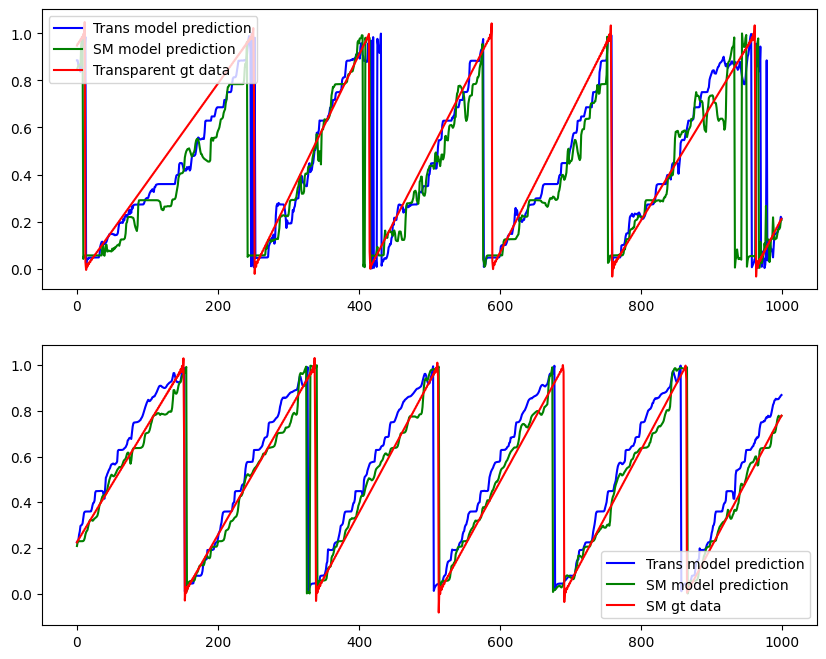

In [217]:

fig, axs = plt.subplots(2, figsize=(10, 8))
axs[0].plot(transform_output(y_pred_trans_trans[:1000]), color="b",  label = "Trans model prediction")
axs[0].plot(transform_output(y_pred_SM_trans[:1000]), color="g", label = "SM model prediction")
axs[0].plot(val_output_transparent[:1000], color='r', label="Transparent gt data")
axs[0].legend()

axs[1].plot(transform_output(y_pred_trans_SM[:1000]), color= "b", label = "Trans model prediction")
axs[1].plot(transform_output(y_pred_SM_SM[:1000]), color ="g", label = "SM model prediction")
axs[1].plot(val_output_SM[:1000], color='r',  label="SM gt data")

axs[1].legend()
plt.show()

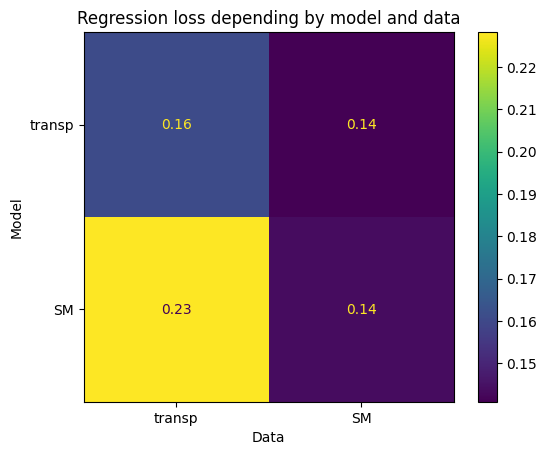

In [218]:
from sklearn.metrics import ConfusionMatrixDisplay

trans_trans_error = np.sqrt(np.mean(np.square(transform_output(y_pred_trans_trans) - val_output_transparent)))
trans_SM_error = np.sqrt(np.mean(np.square(transform_output(y_pred_trans_SM) - val_output_SM)))
SM_trans_error = np.sqrt(np.mean(np.square(transform_output(y_pred_SM_trans) - val_output_transparent)))
SM_SM_error = np.sqrt(np.mean(np.square(transform_output(y_pred_SM_SM) - val_output_SM)))

confusion_matrix = np.array([[trans_trans_error, trans_SM_error],
                             [SM_trans_error, SM_SM_error]])

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["transp", "SM"])
disp.plot(ax=ax, cmap='viridis')
plt.xlabel('Data')
plt.ylabel('Model')
plt.title("Regression loss depending by model and data")
plt.show()

# Part 3: Test on robot